# FS entrainment of SPN

Here we simulate a network of FS neurons connecting to dSPN and iSPN populations. Only the FS neurons are driven by oscillating input, that starts at 2 seconds.

The SPN populations are placed at the centre of the FS population, this is to minimize edge effects on the SPN population's input.

FS gap junction connectivity corresponds to the juvenile case. GABA reversal potential for FS synapses is set to -75mV, and the NMDA component of the FS input has been set to 0. 

FS density is realistic, and SPN density in the core is also realistic (but the SPN will not receive all the feed back inhibition as we only simulate a sub population of SPN in favour of speed).

In [1]:
import os

network_path = os.path.join("networks", "FS_SPN_feed_forward-20Hz-oscillating")

input_name = "FS_SPN_feed_forward-20Hz-oscillating"
sim_file_gj = os.path.join(network_path, "simulation", f"output-GJ-{input_name}.hdf5")
sim_file_nogj = os.path.join(network_path, "simulation", f"output-noGJ-{input_name}.hdf5")

fig_path = os.path.join(network_path, "figures")

input_config = f"{input_name}-input.json"
duration=5
osc_freq = 20

# Number of cores to use for NEURON
n_cores = 8

modified_network = os.path.join(network_path, "network-synapses-ablated.hdf5")

In [ ]:
from snudda.init import SnuddaInit

from snudda.init.init import SnuddaInit
cnc = SnuddaInit(struct_def={}, network_path=network_path, random_seed=1337,
                 snudda_data="../../../../BasalGangliaData/data/")
# To get only FS density we would use 0.013*80500, but then we also have dSPN and iSPN here in network
# so we need to compensate to get the correct FS neuron density (which is the important part)

num_FS = 400
num_dSPN_orig = 14600
num_iSPN_orig = 14600
num_dSPN_final = 40
num_iSPN_final = 40

cnc.define_striatum(num_dSPN=num_dSPN_orig, num_iSPN=num_iSPN_orig, num_FS=num_FS, num_LTS=0, num_ChIN=0,
                    volume_type="cube", neuron_density=0.013*80500*(1 + (num_dSPN_orig + num_iSPN_orig)/num_FS))
cnc.add_population_unit_random("Striatum", "FS", 1.0, 1)

# Overwrite adult GJ connectivity, with higher juvenile connectivity
cnc.add_neuron_target(neuron_name="FS",
                      target_name="FS",
                      connection_type="GapJunction",
                      dist_pruning=None,
                      f1=0.7, soft_max=8, mu2=2, a3=1.0,
                      conductance=[0.5e-9, 0.1e-9],
                      cluster_synapses=False,
                      channel_param_dictionary=None)

# Setting GABA reversal potential to -75mV for FS synapses

pfFSdSPN = os.path.join("$SNUDDA_DATA", "synapses", "striatum", "PlanertFitting-FD-tmgaba-fit.json")
pfFSiSPN = os.path.join("$SNUDDA_DATA", "synapses", "striatum", "PlanertFitting-FI-tmgaba-fit.json")
FS_dist_dep_pruning = "exp(-(0.5*d/60e-6)**2)"

cnc.add_neuron_target(neuron_name="FS",
                      target_name="dSPN",
                      connection_type="GABA",
                      dist_pruning=FS_dist_dep_pruning,
                      f1=0.5, soft_max=5, mu2=2, a3=1.0,
                      conductance=[1.1e-9, 1.5e-9] ,
                      cluster_synapses=False,
                      parameter_file=pfFSdSPN,
                      mod_file="tmGabaA",
                      channel_param_dictionary={"tau1": (1.2e-3, 1e3),
                                                "tau2": (8e-3, 1e3),
                                                "e": -75})
                                                 

cnc.add_neuron_target(neuron_name="FS",
                      target_name="iSPN",
                      connection_type="GABA",
                      dist_pruning=FS_dist_dep_pruning,
                      f1=0.5, soft_max=5, mu2=2, a3=0.9,
                      conductance=[1.1e-9, 1.5e-9] ,
                      cluster_synapses=False,
                      parameter_file=pfFSiSPN,
                      mod_file="tmGabaA",
                      channel_param_dictionary={"tau1": (1.2e-3, 1e3),
                                                "tau2": (8e-3, 1e3),
                                                 "e": -75})

cnc.write_json()

In [ ]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

In [ ]:
!../start_ipcluster.sh 3

In [ ]:
from ipyparallel import Client

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
if os.path.exists(u_file):
    rc = Client(url_file=u_file, timeout=120, debug=False)
else:
    print("Warning, running in serial.")
    rc = None

In [ ]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, verbose=False, rc=rc)
sd.detect()

In [ ]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc)
sp.prune()

In [ ]:
!ipcluster stop

### Ablating network
It is important that the SPN networks receive a full set of FS inputs, so we want to only keep the SPN that are in the core.

In [ ]:
from snudda.utils import SnuddaLoad
from snudda.utils.ablate_network import SnuddaAblateNetwork
mod_network = SnuddaAblateNetwork(network_file=os.path.join(network_path, "network-synapses.hdf5"))
orig_sl = SnuddaLoad(network_path)
orig_fs_id = orig_sl.get_neuron_id_of_type("FS")
orig_dspn_id = [x for x, y in orig_sl.get_centre_neurons_iterator(neuron_type="dSPN", n_neurons=num_dSPN_final)]
orig_ispn_id = [x for x, y in orig_sl.get_centre_neurons_iterator(neuron_type="iSPN", n_neurons=num_iSPN_final)]

keep_id = set(list(orig_fs_id) + list(orig_dspn_id) + list(orig_ispn_id)) 
mod_network.only_keep_neuron_id(keep_id)
mod_network.write_network(modified_network)

Loading 480 neurons with 15823 synapses and 3656 gap junctions
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward-20Hz-oscillating/network-config.json


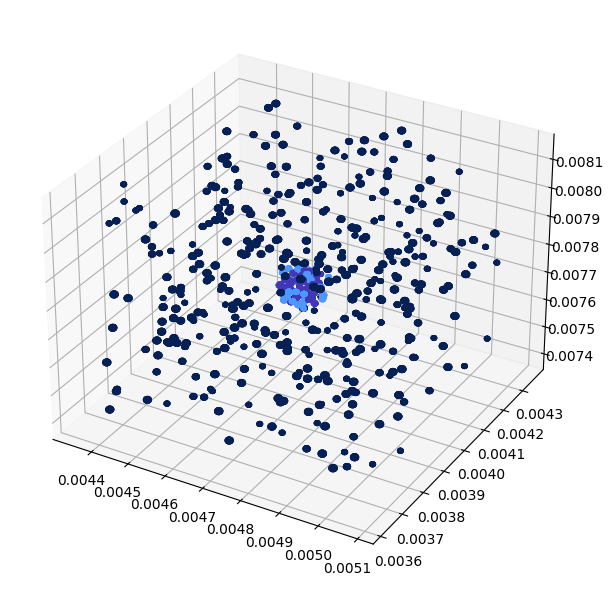

(<module 'matplotlib.pyplot' from '/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>,
 <Axes3DSubplot:>)

In [2]:
from snudda.plotting.plot_network import PlotNetwork
pn = PlotNetwork(modified_network)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)

In [ ]:
from snudda.analyse.analyse import SnuddaAnalyse

nas = SnuddaAnalyse(modified_network, volume_type="cube")
nas.plot_connection_probability("FS", "FS",
                                dist_3d=True,
                                connection_type="gapjunctions",
                                exp_max_dist=[200e-6, 250e-6, 250e-6],
                                exp_data=[6/78.0, 2 / 6.0, 3 / 7.0],
                                exp_data_detailed=[(6, 78), (2, 6), (3, 7)], )

In [ ]:
nas.plot_connection_probability("FS", "iSPN",
                                dist_3d=True,
                                exp_max_dist=[100e-6, 150e-6, 250e-6],
                                exp_data=[6 / 9.0, 21 / 54.0, 27 / 77.0],
                                exp_data_detailed=[(6, 9), (21, 54), (27, 77)],
                                y_max=None)

nas.plot_connection_probability("FS", "dSPN",
                                dist_3d=True,
                                exp_max_dist=[100e-6, 150e-6, 250e-6],
                                exp_data=[8 / 9.0, 29 / 48.0, 48 / 90.0],
                                exp_data_detailed=[(8, 9), (29, 48), (48, 90)],
                                y_max=None)

### Generate input

In [ ]:
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path,
                 hdf5_network_file=modified_network,
                 input_config_file=f"{input_name}-input.json",
                 verbose=False)
si.generate()

In [ ]:
from snudda.plotting import PlotInput
input_file = os.path.join(network_path, "input-spikes.hdf5")
spi = PlotInput(input_file, network_path=modified_network)
spi.plot_input(neuron_type="FS", num_neurons=3)
spi.plot_input(neuron_type="dSPN", num_neurons=2)
spi.plot_input(neuron_type="iSPN", num_neurons=2)

In [ ]:
os.system(f"mpiexec -n {n_cores} snudda simulate {network_path} --networkFile {modified_network} --time {duration} --outputFile {sim_file_gj}")

In [ ]:
os.system(f"mpiexec -n {n_cores} snudda simulate {network_path} --networkFile {modified_network} --time {duration} --outputFile {sim_file_nogj} --disableGJ")

### Figures

In [3]:
from snudda.utils import SnuddaLoad
from snudda.utils import SnuddaLoadNetworkSimulation

sl = SnuddaLoad(modified_network)
sls_gj = SnuddaLoadNetworkSimulation(network_simulation_output_file=sim_file_gj)
sls_nogj = SnuddaLoadNetworkSimulation(network_simulation_output_file=sim_file_nogj)

n_centre=10

nid_fs = [x for x,y in sl.get_centre_neurons_iterator(n_neurons=n_centre, neuron_type="FS")]
nid_dspn = [x for x,y in sl.get_centre_neurons_iterator(n_neurons=n_centre, neuron_type="dSPN")]
nid_ispn = [x for x,y in sl.get_centre_neurons_iterator(n_neurons=n_centre, neuron_type="iSPN")]

Loading 480 neurons with 15823 synapses and 3656 gap junctions
Loading networks/FS_SPN_feed_forward-20Hz-oscillating/simulation/output-GJ-FS_SPN_feed_forward-20Hz-oscillating.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
22: (FS_0, p4feff98b, m86da4874)
24: (FS_0, p4feff98b, m4cd420e2)
25: (FS_0, pb1ef6b01, m4cd420e2)
26: (FS_0, p59a48310, m86da4874)
27: (FS_1, p31916918, m9d1605c7)
28: (FS_1, p31916918, m48f576bb)
29: (FS_1, pf9439e45, m9d1605c7)
37: (FS_0, p4feff98b, m4fdebda2)
41: (FS_1, pf86c86e4, ma88f99b9)
45: (FS_1, p6eb0c221, m9d1605c7)
47: (FS_1, pf86c86e4, m868d56db)
54: (FS_1, p31916918, meffc0dfa)
61: (FS_0, p4feff98b, m4cd420e2)
66: (FS_1, pf86c86e4, meffc0dfa)
69: (FS_0, pb1ef6b01, mb1b67bcc)
71: (FS_0, pb1ef6b01, mb1b67bcc)
87: (FS_1, pf86c86e4, meffc0dfa)
102: (FS_0, p59a48310, m15ae4048)
105: (FS_0, p59a48310, m86da4874)
111: (FS_1, p6eb0c221, meffc0dfa)
144: (iSPN_0, p039c9f4f, m3a845add)
147: (iSPN_0, p635b801c, m3a8

Loading network info from networks/FS_SPN_feed_forward-20Hz-oscillating/network-synapses-ablated.hdf5
Loading 480 neurons with 15823 synapses and 3656 gap junctions
Loading input info from networks/FS_SPN_feed_forward-20Hz-oscillating/input-spikes.hdf5
Loading networks/FS_SPN_feed_forward-20Hz-oscillating/simulation/output-GJ-FS_SPN_feed_forward-20Hz-oscillating.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
22: (FS_0, p4feff98b, m86da4874)
24: (FS_0, p4feff98b, m4cd420e2)
25: (FS_0, pb1ef6b01, m4cd420e2)
26: (FS_0, p59a48310, m86da4874)
27: (FS_1, p31916918, m9d1605c7)
28: (FS_1, p31916918, m48f576bb)
29: (FS_1, pf9439e45, m9d1605c7)
37: (FS_0, p4feff98b, m4fdebda2)
41: (FS_1, pf86c86e4, ma88f99b9)
45: (FS_1, p6eb0c221, m9d1605c7)
47: (FS_1, pf86c86e4, m868d56db)
54: (FS_1, p31916918, meffc0dfa)
61: (FS_0, p4feff98b, m4cd420e2)
66: (FS_1, pf86c86e4, meffc0dfa)
69: (FS_0, pb1ef6b01, mb1b67bcc)
71: (FS_0, pb1ef6b01, mb1b67bcc)
87: (FS_1,

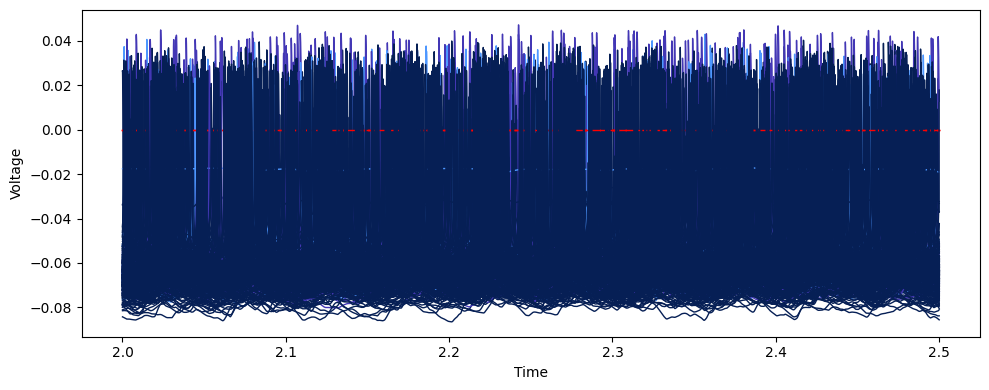

In [4]:
%matplotlib inline

from snudda.plotting.plot_traces import PlotTraces
pt = PlotTraces(output_file=sim_file_gj, network_file=modified_network)
# Use trace_id to specify which traces
ax = pt.plot_traces(offset=0, time_range=(2,2.5),fig_size=(10,4))

Loading network info from networks/FS_SPN_feed_forward-20Hz-oscillating/network-synapses-ablated.hdf5
Loading 480 neurons with 15823 synapses and 3656 gap junctions
Loading input info from networks/FS_SPN_feed_forward-20Hz-oscillating/input-spikes.hdf5
Loading networks/FS_SPN_feed_forward-20Hz-oscillating/simulation/output-noGJ-FS_SPN_feed_forward-20Hz-oscillating.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
22: (FS_0, p4feff98b, m86da4874)
26: (FS_0, p59a48310, m86da4874)
27: (FS_1, p31916918, m9d1605c7)
29: (FS_1, pf9439e45, m9d1605c7)
37: (FS_0, p4feff98b, m4fdebda2)
41: (FS_1, pf86c86e4, ma88f99b9)
66: (FS_1, pf86c86e4, meffc0dfa)
71: (FS_0, pb1ef6b01, mb1b67bcc)
74: (FS_0, p59a48310, m9175e580)
80: (FS_1, pf9439e45, m9d1605c7)
102: (FS_0, p59a48310, m15ae4048)
103: (FS_0, p59a48310, m4fdebda2)
105: (FS_0, p59a48310, m86da4874)
132: (dSPN_1, p961b899b, mc44c4566)
142: (dSPN_3, p1dc65e22, m615b0265)
147: (iSPN_0, p635b801c, m3a845a

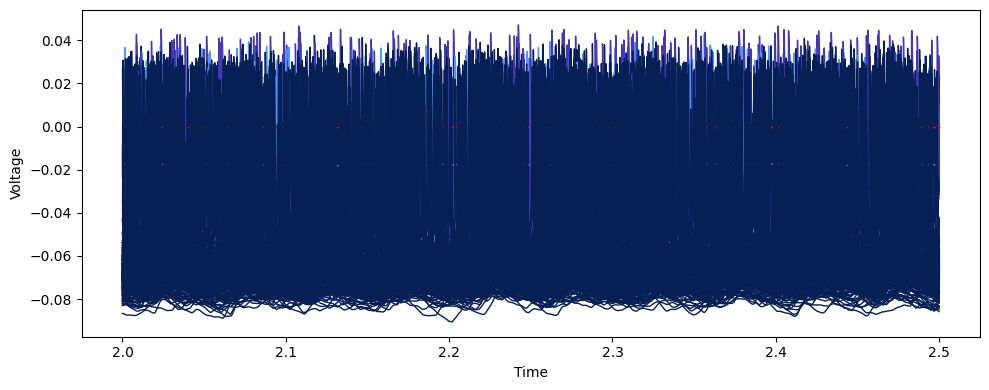

In [5]:
from snudda.plotting.plot_traces import PlotTraces
pt2 = PlotTraces(output_file=sim_file_nogj, network_file=modified_network)
ax2 = pt2.plot_traces(offset=0, time_range=(2,2.5),fig_size=(10,4))

Writing figure to networks/FS_SPN_feed_forward-20Hz-oscillating/figures/Period-histogram-FS_SPN_feed_forward-20Hz-oscillating-GJ.png


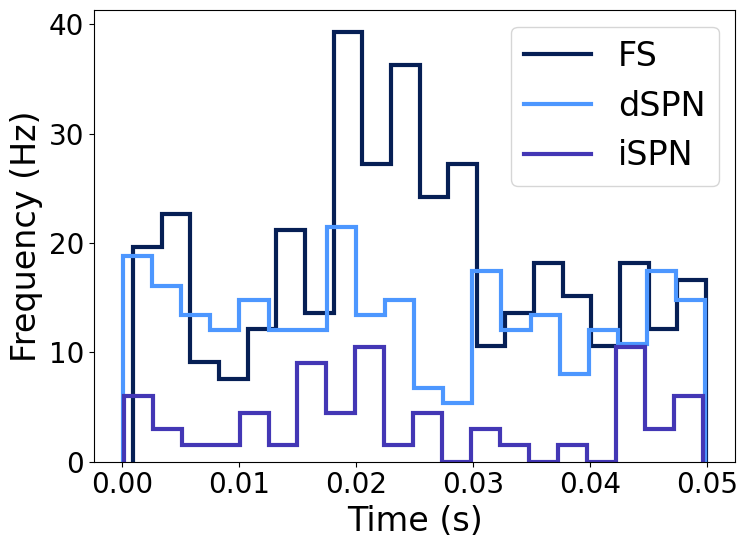

In [6]:
from snudda.plotting import PlotPeriodExperiment
spr = PlotPeriodExperiment(network_path=network_path,
                             network_file=modified_network,
                             simulation_file=sim_file_gj,
                             snudda_load=sl, snudda_simulation_load=sls_gj)
time_range = (2,3.5)
n_bins = 20
fig_name_ph_gj = f"Period-histogram-{input_name}-GJ.png"
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, time_range=time_range, label="FS", color=spr.get_colours("FS"), show_figure=False,
                                         exclude_depolarisation_blocked_neurons=True, save_figure=False, fig_size=(8,6), n_bins=n_bins)
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, time_range=time_range, label="dSPN", ax=ax, color=spr.get_colours("dSPN"), show_figure=False,
                                        exclude_depolarisation_blocked_neurons=True, save_figure=False, n_bins=n_bins)
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, time_range=time_range, label="iSPN", ax=ax, color=spr.get_colours("iSPN"),
                                        exclude_depolarisation_blocked_neurons=True, fig_file=fig_name_ph_gj, n_bins=n_bins)

Writing figure networks/FS_SPN_feed_forward-20Hz-oscillating/figures/FS_SPN_feed_forward-20Hz-oscillating-spike-histogram-GJ.png


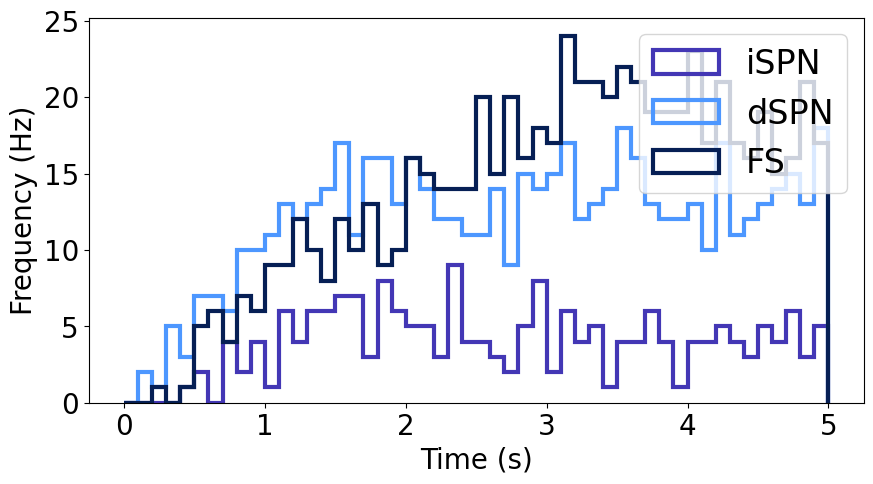

<AxesSubplot:xlabel='Time (s)', ylabel='Frequency (Hz)'>

In [7]:
fig_name_sh_gj = f"{input_name}-spike-histogram-GJ.png"
spr.plot_spike_histogram_type(["FS", "dSPN", "iSPN"], bin_size=100e-3, n_core=10, fig_file=fig_name_sh_gj, linestyle="-", fig_size=(10,5))

Writing figure to networks/FS_SPN_feed_forward-20Hz-oscillating/figures/Period-histogram-FS_SPN_feed_forward-20Hz-oscillating-noGJ.png


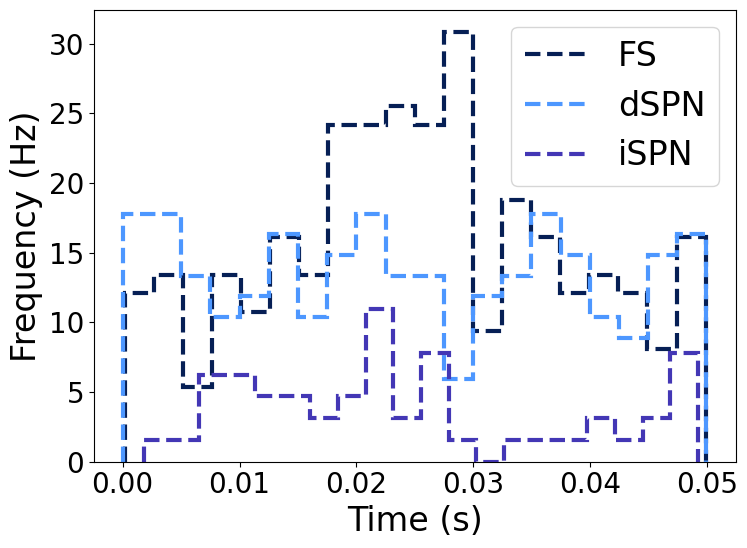

In [8]:
from snudda.plotting import PlotPeriodExperiment
spr2 = PlotPeriodExperiment(network_path=network_path, 
                              network_file=modified_network,
                              simulation_file=sim_file_nogj,
                              snudda_load=sl, snudda_simulation_load=sls_nogj)

fig_name_ph_nogj = f"Period-histogram-{input_name}-noGJ.png"
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, time_range=time_range, label="FS", color=spr.get_colours("FS"), show_figure=False,
                                          exclude_depolarisation_blocked_neurons=True, save_figure=False, fig_size=(8,6), n_bins=n_bins, linestyle="--")
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, time_range=time_range, label="dSPN", ax=ax, color=spr.get_colours("dSPN"), show_figure=False,
                                         exclude_depolarisation_blocked_neurons=True, save_figure=False, n_bins=n_bins, linestyle="--")
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, time_range=time_range, label="iSPN", ax=ax, color=spr.get_colours("iSPN"),
                                         exclude_depolarisation_blocked_neurons=True, fig_file=fig_name_ph_nogj, n_bins=n_bins, linestyle="--")

Writing figure networks/FS_SPN_feed_forward-20Hz-oscillating/figures/FS_SPN_feed_forward-20Hz-oscillating-spike-histogram-noGJ.png


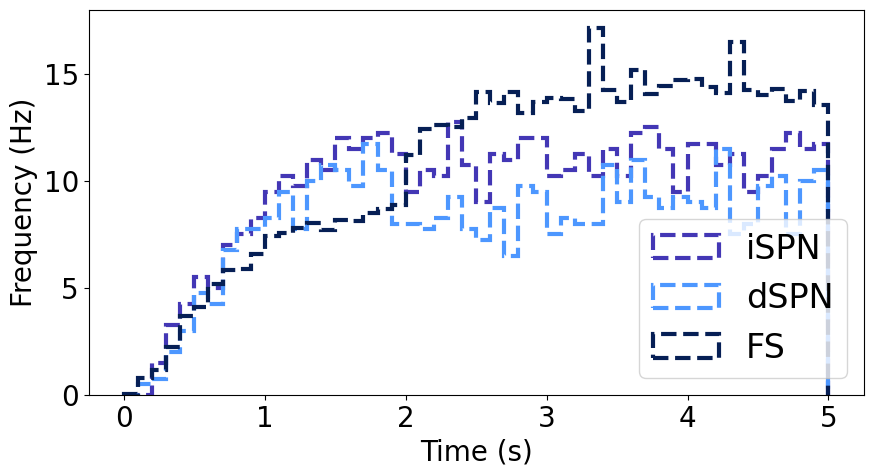

<AxesSubplot:xlabel='Time (s)', ylabel='Frequency (Hz)'>

In [9]:
fig_name_sh_nogj = f"{input_name}-spike-histogram-noGJ.png"

spr2.plot_spike_histogram_type(["FS", "dSPN", "iSPN"], bin_size=100e-3, fig_file=fig_name_sh_nogj, linestyle="--", legend_loc="lower right", fig_size=(10,5))

Comparing with and without gap junctions

Writing figure to networks/FS_SPN_feed_forward-20Hz-oscillating/figures/Period-histogram-FS_SPN_feed_forward-20Hz-oscillating-summary.png


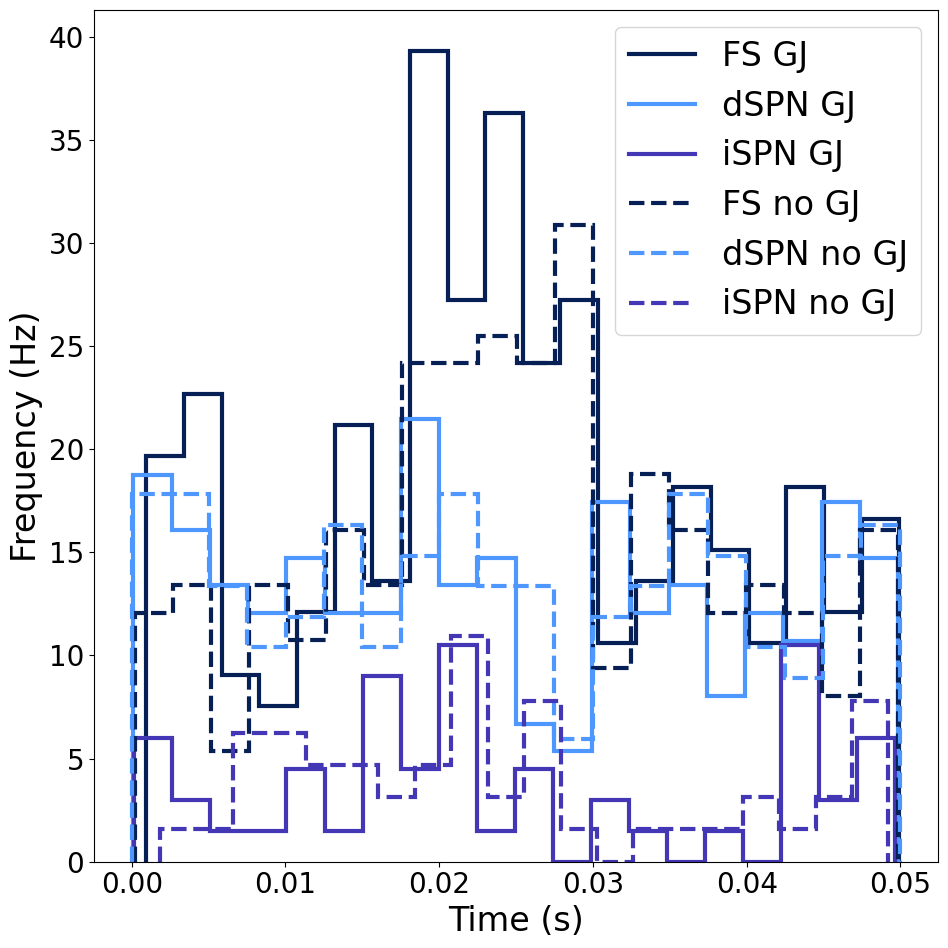

In [10]:
fig_name_ph = f"Period-histogram-{input_name}-summary.png"
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, time_range=time_range, label="FS GJ", color=spr.get_colours("FS"), show_figure=False, fig_size=(10,10),
                                         exclude_depolarisation_blocked_neurons=True, save_figure=False, linestyle="-", n_bins=n_bins)
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, time_range=time_range, label="dSPN GJ", ax=ax, color=spr.get_colours("dSPN"), show_figure=False,
                                        exclude_depolarisation_blocked_neurons=True, save_figure=False, linestyle="-", n_bins=n_bins)
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, time_range=time_range, label="iSPN GJ", ax=ax, color=spr.get_colours("iSPN"), show_figure=False,
                                        exclude_depolarisation_blocked_neurons=True, save_figure=False, linestyle="-", n_bins=n_bins)
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, time_range=time_range, label="FS no GJ", ax=ax, color=spr.get_colours("FS"), show_figure=False,
                                          exclude_depolarisation_blocked_neurons=True, save_figure=False, linestyle="--", n_bins=n_bins)
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, time_range=time_range, label="dSPN no GJ", ax=ax, color=spr.get_colours("dSPN"), show_figure=False,
                                         exclude_depolarisation_blocked_neurons=True, save_figure=False, linestyle="--", n_bins=n_bins)
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, time_range=time_range, label="iSPN no GJ", ax=ax, color=spr.get_colours("iSPN"),
                                         exclude_depolarisation_blocked_neurons=True, fig_file=fig_name_ph, linestyle="--", n_bins=n_bins)

Saving figure to networks/FS_SPN_feed_forward-20Hz-oscillating/figures/FS_SPN_feed_forward-20Hz-oscillating-spike-raster-GJ.png


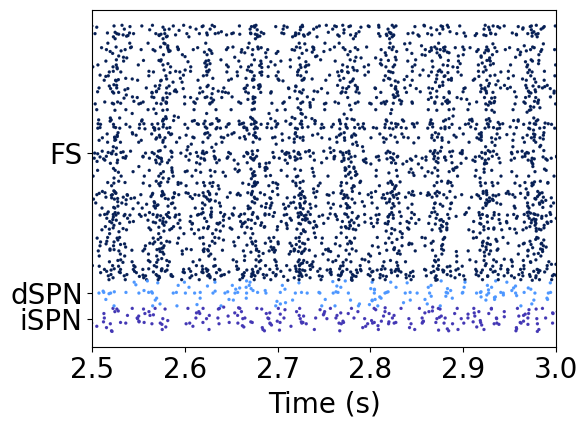

Saving figure to networks/FS_SPN_feed_forward-20Hz-oscillating/figures/FS_SPN_feed_forward-20Hz-oscillating-spike-raster-noGJ.png


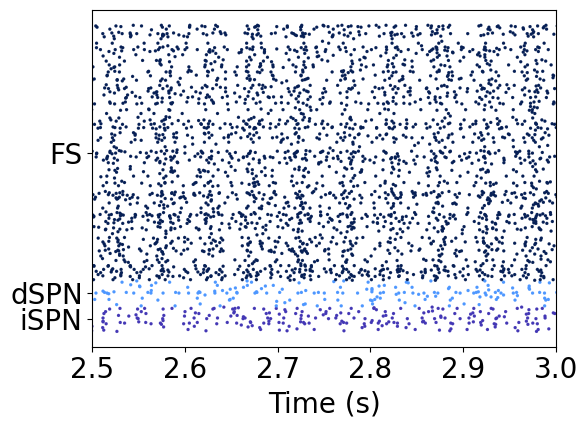

In [11]:
fig_file_raster_gj = f"{input_name}-spike-raster-GJ.png"
fig_file_raster_nogj = f"{input_name}-spike-raster-noGJ.png"

time_range_zoom = (2.5,3)

spr.plot_spike_raster(fig_file=fig_file_raster_gj, time_range=time_range_zoom)
spr2.plot_spike_raster(fig_file=fig_file_raster_nogj, time_range=time_range_zoom)

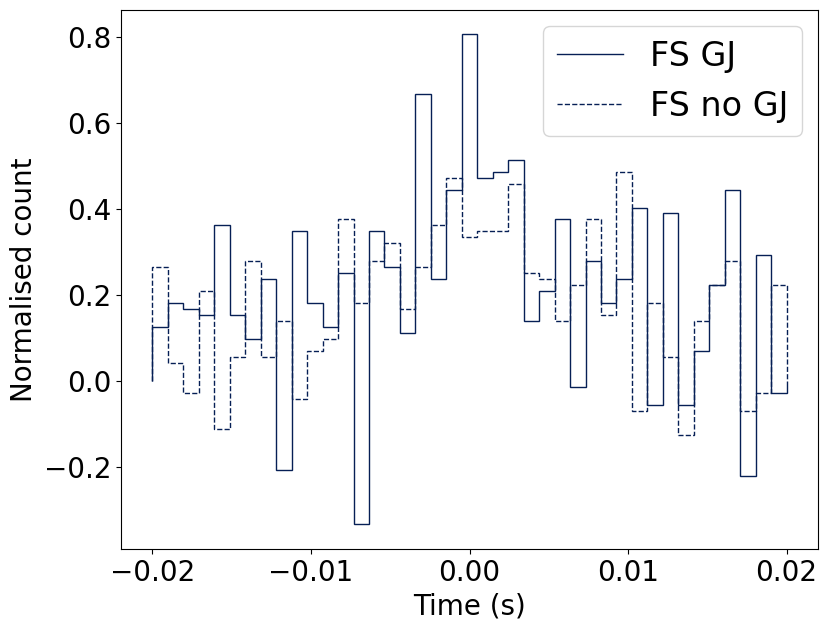

<Figure size 640x480 with 0 Axes>

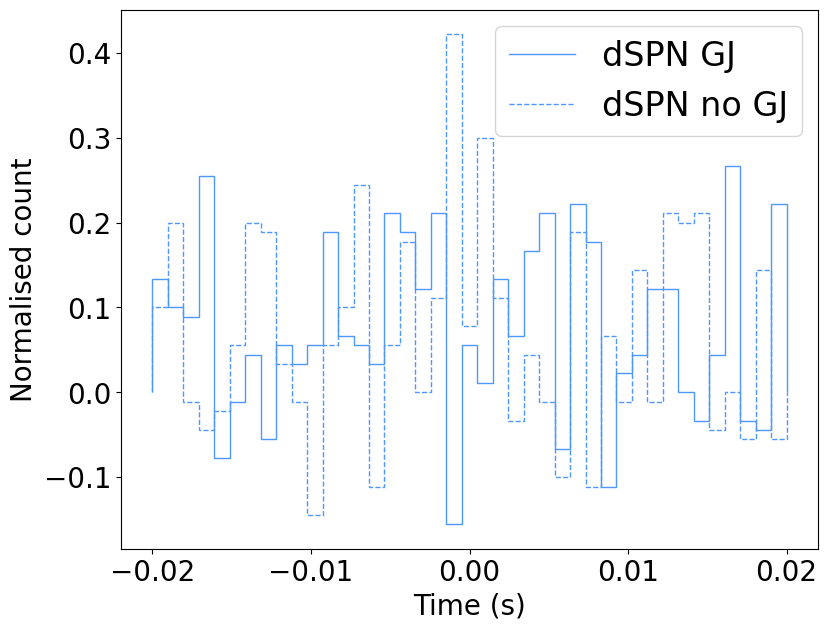

<Figure size 640x480 with 0 Axes>

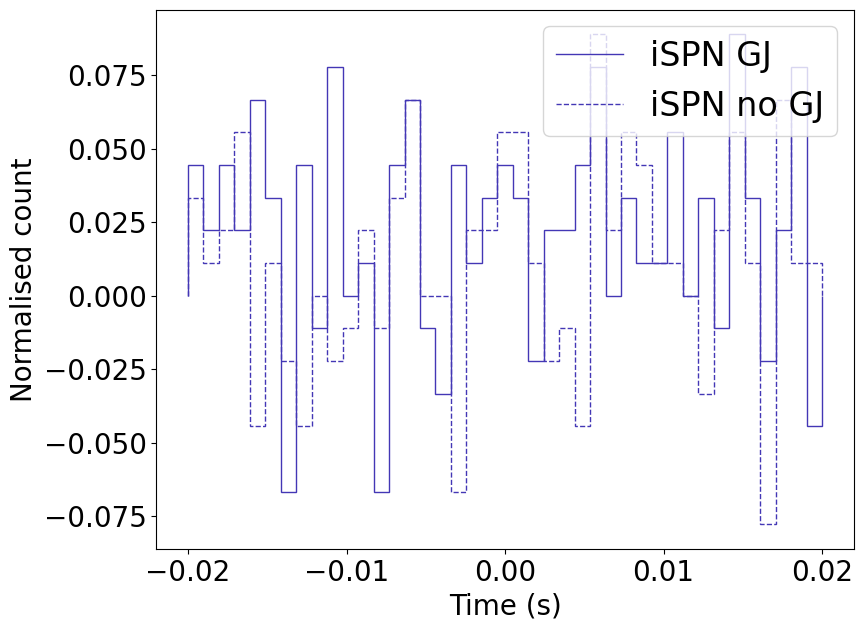

<AxesSubplot:xlabel='Time (s)', ylabel='Normalised count'>

<Figure size 640x480 with 0 Axes>

In [12]:
from snudda.plotting.plot_cross_correlogram import PlotCrossCorrelogram

fig_file_fs=os.path.join(fig_path, f"{input_name}-shuffle-corrected-cross-correlogram-FS.png")
fig_file_dspn=os.path.join(fig_path, f"{input_name}-shuffle-corrected-cross-correlogram-dSPN.png")
fig_file_ispn=os.path.join(fig_path, f"{input_name}-shuffle-corrected-cross-correlogram-iSPN.png")

pcc = PlotCrossCorrelogram(simulation_file=sim_file_gj, snudda_simulation_load=sls_gj)
pcc2 = PlotCrossCorrelogram(simulation_file=sim_file_nogj, snudda_simulation_load=sls_nogj)

fs_colour = spr.get_colours("FS")
dspn_colour = spr.get_colours("dSPN")
ispn_colour = spr.get_colours("iSPN")

# Pick centre FS only, use same number as for dSPN
nid_fs_center = [x for x, y in sl.get_centre_neurons_iterator(neuron_type="FS", n_neurons=len(nid_dspn))]

n_bins= 41
width = 20e-3

ax = pcc.plot_all_pair_cross_correlogram(neuron_id=nid_fs_center, show_figure=False, linestyle="-", label="FS GJ", colour=fs_colour, n_bins=n_bins, width=width, fig_size=(9,7))
pcc2.plot_all_pair_cross_correlogram(neuron_id=nid_fs_center, show_figure=True, linestyle="--", ax=ax, label="FS no GJ", fig_file_name=fig_file_fs, colour=fs_colour, n_bins=n_bins, width=width)

ax = pcc.plot_all_pair_cross_correlogram(neuron_id=nid_dspn, show_figure=False, linestyle="-", label="dSPN GJ", colour=dspn_colour, n_bins=n_bins, width=width, fig_size=(9,7))
pcc2.plot_all_pair_cross_correlogram(neuron_id=nid_dspn, show_figure=True, linestyle="--", ax=ax, label="dSPN no GJ", fig_file_name=fig_file_dspn, colour=dspn_colour, n_bins=n_bins, width=width)

ax = pcc.plot_all_pair_cross_correlogram(neuron_id=nid_ispn, show_figure=False, linestyle="-", label="iSPN GJ", colour=ispn_colour, n_bins=n_bins, width=width, fig_size=(9,7))
pcc2.plot_all_pair_cross_correlogram(neuron_id=nid_ispn, show_figure=True, linestyle="--", ax=ax, label="iSPN no GJ", fig_file_name=fig_file_ispn, colour=ispn_colour, n_bins=n_bins, width=width)

## TODO: Look at SPN connected to FS that spike

- For each FS spike, find voltage in the connected SPN. Average the SPN voltage. Compare GJ and no GJ cases.

- Try to have 10Hz FS spiking from background, 25Hz with oscillations on top. Ie, decrease background input. Increase oscillation input (correlation of it, or absolute frequency?)